In [1]:
import sys
import jax.numpy as jnp

sys.path.append('../')

from matrix_builder import elmfbpinn

In [2]:
# Damped Harmonic Oscillator parameters
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)


# Damped harmonic oscillator solution and its derivatives
def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega_0 * t)


def zero_RHS(t):
    return 0.0 * harm_u_exact(t)

Epoch 0, Loss: 0.329684
Epoch 50000, Loss: 0.056633
Epoch 100000, Loss: 0.037789
Epoch 150000, Loss: 0.030145


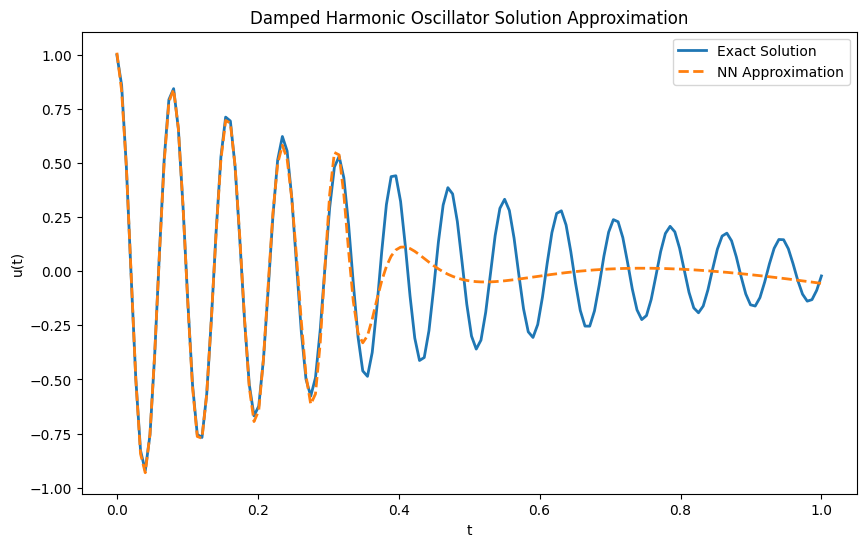

In [8]:
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial

# Set random seed for reproducibility
key = random.PRNGKey(42)

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega * t)

# Generate training data
x_batch = jnp.linspace(0, 1, 150)  # Input data (time values)
u_ground = harm_u_exact(x_batch)    # Ground truth solution

# Define the feed-forward neural network
def initialize_mlp(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes) - 1)
    for in_size, out_size, k in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weight = random.normal(k, (in_size, out_size)) * jnp.sqrt(1 / in_size)
        bias = jnp.zeros(out_size)
        params.append((weight, bias))
    return params

def mlp_forward(params, x):
    for weight, bias in params[:-1]:
        x = jnp.tanh(jnp.dot(x, weight) + bias)
    final_weight, final_bias = params[-1]
    return jnp.dot(x, final_weight) + final_bias

# Loss function (Mean Squared Error)
def mse_loss(params, x, y):
    preds = jax.vmap(partial(mlp_forward, params))(x)
    return jnp.mean((preds - y)**2)

# Training step
@partial(jax.jit, static_argnums=(4,))
def train_step(params, opt_state, x, y, optimizer):
    loss, grads = jax.value_and_grad(mse_loss)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Hyperparameters
layer_sizes = [1, 64, 1]  # Input layer, two hidden layers, output layer
learning_rate = 1e-3
epochs = 200000

# Initialize model and optimizer
key, subkey = random.split(key)
params = initialize_mlp(layer_sizes, subkey)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Reshape inputs for the neural network
x_train = x_batch[:, None]  # Shape (300, 1)
y_train = u_ground[:, None]  # Shape (300, 1)

# Training loop
for epoch in range(epochs):
    params, opt_state, loss = train_step(params, opt_state, x_train, y_train, optimizer)
    if epoch % 50000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# Evaluate the model
u_pred = jax.vmap(partial(mlp_forward, params))(x_train).flatten()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_batch, u_ground, label="Exact Solution", linewidth=2)
plt.plot(x_batch, u_pred, label="NN Approximation", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Damped Harmonic Oscillator Solution Approximation")
plt.legend()
plt.show()

In [9]:
trained_hidden_weights = params[0][0] # Shape (1, 64)
trained_hidden_bias = params[0][1]  #shape (64,)

In [10]:
trained_hidden_weights


Array([[-1.8654226e+01, -1.6559146e-01,  1.3264614e-01,  3.3505218e+00,
        -3.6241695e+01,  1.5185680e+00,  1.3975614e+00, -2.4571086e-01,
         2.8735388e+01, -5.3560740e-01,  3.9426297e-01,  6.8043464e-01,
         5.7895285e-01, -7.8415310e-01, -1.0133410e+01, -1.4810687e+00,
         1.0523264e+01,  4.5739573e-01,  8.7640867e-02, -7.7190334e-01,
         2.9389240e+01,  3.1198259e+01, -9.8557627e-01,  3.1721394e+01,
         4.2260318e+00, -1.7451740e+01, -8.0108337e+00,  7.5236177e+00,
        -2.8750669e+01,  7.1725693e+00, -5.6418699e-01, -6.7970883e-03,
        -8.5235462e+00,  3.0411419e+01, -1.6245036e-01, -1.4491284e+01,
        -6.0100861e+00,  6.9487369e-01, -3.1820414e+00, -1.2134777e+00,
        -7.7878511e-01, -6.4676166e-02, -6.2832409e-01, -1.4596953e+00,
        -2.4164164e+01, -5.5705327e-01, -4.3374019e+00,  3.2881759e-02,
        -3.3432809e-01,  5.8536100e+00, -2.5450953e+01, -6.0194507e+00,
         1.5217601e+01,  3.5488522e+00,  3.2386631e+01, -3.67216

Creating M_ode...
M_ode created in 2.78 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 1.83 seconds.
B_train scaled
Time taken for solver: 0.0101 seconds
a calculated in 0.64 seconds.
Creating M_sol...
M_sol created in 2.08 seconds.
Loss Value: 9.54e-03
Test Loss Value: 9.54e-03


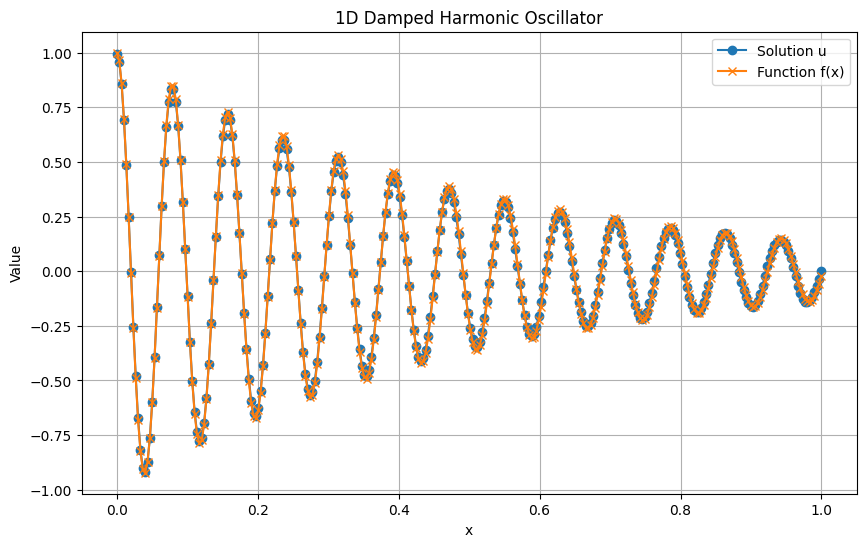

Condition number of M_ode_scaled: 1.69e+09
Condition number of M_sol: 2.99e+09
Condition Number of LHS: 1.07e+12
Total time taken: 10.08 seconds.


In [6]:
RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=20
C=32
R=25
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
)

Creating M_ode...
M_ode created in 1.68 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.65 seconds.
B_train scaled


/home/ophunix/ELM-FBPINN/elmfbpinns/example/../solvers.py:44: MatrixRankWarning: Matrix is exactly singular
  a = splinalg.spsolve(LHS, RHS)


Time taken for solver: 0.0306 seconds
a calculated in 1.20 seconds.
Creating M_sol...
M_sol created in 0.33 seconds.
Loss Value: nan
Test Loss Value: nan


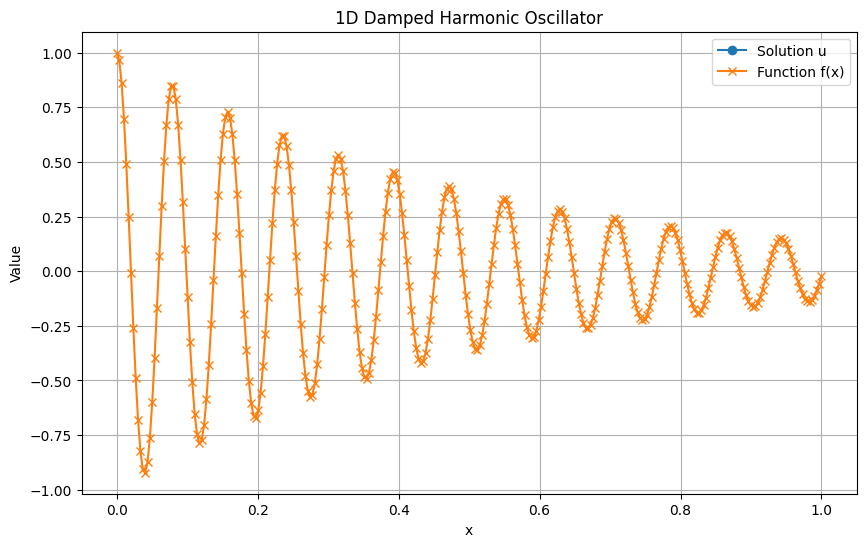

Condition number of M_ode_scaled: 1.05e+08
Condition number of M_sol: 2.99e+09
Condition Number of LHS: inf
Total time taken: 4.13 seconds.


In [11]:
RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=20
C=64
R=25
width = 1.9
sigma = jnp.tanh
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    trained_hidden_weights.flatten(),
    trained_hidden_bias,
    lmda=1,
    plot_window=False,
)